In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import pandas as pd
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
import os
import copy

plt.ion()  

use_gpu = torch.cuda.is_available()

# device = torch.device('cpu')
device = None
if use_gpu:
    device = torch.device('cuda:0')
    print("Using CUDA")
else:
    device = torch.device('cpu')
    print("Using CPU")
    
torch.manual_seed(54)

Using CUDA


In [2]:
# !pip install gputil

# import torch
# from GPUtil import showUtilization as gpu_usage
# from numba import cuda

# def free_gpu_cache():
#     print("Initial GPU Usage")
#     gpu_usage()                             

#     torch.cuda.empty_cache()

#     cuda.select_device(0)
#     cuda.close()
#     cuda.select_device(0)

#     print("GPU Usage after emptying the cache")
#     gpu_usage()

# free_gpu_cache()  






# ****Data preprocessing****

In [3]:
df = pd.read_csv('/kaggle/input/nih-chest-x-ray-14-224x224-resized/Data_Entry_2017.csv')

df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000001_000.png,Cardiomegaly,0,1,058Y,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,058Y,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2,1,058Y,M,PA,2500,2048,0.168,0.168,NaN
3,00000002_000.png,No Finding,0,2,081Y,M,PA,2500,2048,0.171,0.171,NaN
4,00000003_000.png,Hernia,0,3,081Y,F,PA,2582,2991,0.143,0.143,NaN


In [4]:
df.describe()

,Follow-up #,Patient ID,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
count,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,0.0
mean,8.573751,14346.381743,2646.078844,2486.438842,0.155649,0.155649,NaN
std,15.406320,8403.876972,341.246429,401.268227,0.016174,0.016174,NaN
min,0.000000,1.000000,1143.000000,966.000000,0.115000,0.115000,NaN
25%,0.000000,7310.750000,2500.000000,2048.000000,0.143000,0.143000,NaN
50%,3.000000,13993.000000,2518.000000,2544.000000,0.143000,0.143000,NaN
75%,10.000000,20673.000000,2992.000000,2991.000000,0.168000,0.168000,NaN
max,183.000000,30805.000000,3827.000000,4715.000000,0.198800,0.198800,NaN


In [5]:
df.count()

Image Index                    112120
Finding Labels                 112120
Follow-up #                    112120
Patient ID                     112120
Patient Age                    112120
Patient Gender                 112120
View Position                  112120
OriginalImage[Width            112120
Height]                        112120
OriginalImagePixelSpacing[x    112120
y]                             112120
Unnamed: 11                         0
dtype: int64

In [6]:
df[df['Image Index'].isna()].count()

Image Index                    0
Finding Labels                 0
Follow-up #                    0
Patient ID                     0
Patient Age                    0
Patient Gender                 0
View Position                  0
OriginalImage[Width            0
Height]                        0
OriginalImagePixelSpacing[x    0
y]                             0
Unnamed: 11                    0
dtype: int64

In [7]:
df[df['Finding Labels'] == 'No Finding'].count()

Image Index                    60412
Finding Labels                 60412
Follow-up #                    60412
Patient ID                     60412
Patient Age                    60412
Patient Gender                 60412
View Position                  60412
OriginalImage[Width            60412
Height]                        60412
OriginalImagePixelSpacing[x    60412
y]                             60412
Unnamed: 11                        0
dtype: int64

In [8]:
df = df.drop(df[df['Finding Labels'] == 'No Finding'].index)

In [9]:
labels = ['atelectasis', 'cardiomegaly', 'consolidation', 'edema', 'effusion', 'emphysema', 'fibrosis',
          'hernia', 'infiltration', 'mass', 'nodule', 'pleural_thickening', 'pneumonia', 'pneumothorax']

In [10]:
len(labels)

14

In [11]:
df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000001_000.png,Cardiomegaly,0,1,058Y,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,058Y,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2,1,058Y,M,PA,2500,2048,0.168,0.168,NaN
4,00000003_000.png,Hernia,0,3,081Y,F,PA,2582,2991,0.143,0.143,NaN
5,00000003_001.png,Hernia,1,3,074Y,F,PA,2500,2048,0.168,0.168,NaN


In [12]:

df = df.drop(df.columns.difference(['Image Index', 'Finding Labels']), axis=1)

In [13]:
from sklearn.preprocessing import MultiLabelBinarizer
label_mlb = []
for label in df['Finding Labels'].values:
    splits = label.split('|')
    label_mlb.append(set(splits))

mlb = MultiLabelBinarizer()
label_array = mlb.fit_transform(label_mlb)

In [14]:
mlb.classes_

array(['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema',
       'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration',
       'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia',
       'Pneumothorax'], dtype=object)

In [15]:
final_df = pd.DataFrame(label_array, columns=mlb.classes_)
final_df.insert(loc=0, column='Image', value=df['Image Index'].values)
final_df.head()

,Image,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000001_000.png,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,00000001_001.png,0,1,0,0,0,1,0,0,0,0,0,0,0,0
2,00000001_002.png,0,1,0,0,1,0,0,0,0,0,0,0,0,0
3,00000003_000.png,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,00000003_001.png,0,0,0,0,0,0,0,1,0,0,0,0,0,0







#  Creating dataset

In [16]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image

In [17]:

class ChestXRayDataset(Dataset):
    def __init__(self, root, df, transform=None):
        self.root = root
        self.df = df
        self.transform = transform
        
        file = open(self.root)
        images = file.read().splitlines()
        
        ids = []
        
        for idx, path in enumerate(self.df['Image']):
            if path in images:
                ids.append(idx)
        
        self.df = self.df.iloc[ids, :].reset_index(drop=True)
        self.images = self.df['Image'].values
        self.labels = self.df.iloc[:, 1:].values
    
        labels = list(map(lambda x: x.lower(), self.df.columns[1:]))
        self.classes = {v: k for k, v in enumerate(labels)}
        
    def __getitem__(self, item):
        img = Image.open(
            f'/kaggle/input/nih-chest-x-ray-14-224x224-resized/images-224/images-224/{self.images[item]}'
        )
#         img = np.expand_dims(img, axis=-1)
#         img = img.repeat(3, axis=-1)
        
        if self.transform is not None:
            img = self.transform(img)
            
        return img, torch.tensor(self.labels[item], dtype=torch.float32)
    
    def __len__(self):
        return len(self.df)

In [18]:
basic_transform = torchvision.transforms.Compose([
                                          torchvision.transforms.Grayscale(num_output_channels=3), 
                                          torchvision.transforms.Resize((299, 299)),
                                          torchvision.transforms.ToTensor()
                                          ])

In [19]:
train_dataset = ChestXRayDataset(
    root='/kaggle/input/nih-chest-x-ray-14-224x224-resized/train_val_list_NIH.txt',
    df=final_df,
    transform=basic_transform
)

In [20]:
test_dataset = ChestXRayDataset(
    root='/kaggle/input/nih-chest-x-ray-14-224x224-resized/test_list_NIH.txt',
    df=final_df,
    transform=basic_transform
)

In [21]:
len(train_dataset), train_dataset[0]

(36024,
 (tensor([[[0.7529, 0.7373, 0.7020,  ..., 0.0196, 0.0196, 0.0157],
           [0.7294, 0.6980, 0.6275,  ..., 0.0196, 0.0196, 0.0157],
           [0.6902, 0.6235, 0.5098,  ..., 0.0196, 0.0196, 0.0157],
           ...,
           [0.9882, 0.9333, 0.8353,  ..., 0.0078, 0.0000, 0.0000],
           [0.9882, 0.9333, 0.8353,  ..., 0.0118, 0.0000, 0.0000],
           [0.9922, 0.9373, 0.8392,  ..., 0.0157, 0.0000, 0.0000]],
  
          [[0.7529, 0.7373, 0.7020,  ..., 0.0196, 0.0196, 0.0157],
           [0.7294, 0.6980, 0.6275,  ..., 0.0196, 0.0196, 0.0157],
           [0.6902, 0.6235, 0.5098,  ..., 0.0196, 0.0196, 0.0157],
           ...,
           [0.9882, 0.9333, 0.8353,  ..., 0.0078, 0.0000, 0.0000],
           [0.9882, 0.9333, 0.8353,  ..., 0.0118, 0.0000, 0.0000],
           [0.9922, 0.9373, 0.8392,  ..., 0.0157, 0.0000, 0.0000]],
  
          [[0.7529, 0.7373, 0.7020,  ..., 0.0196, 0.0196, 0.0157],
           [0.7294, 0.6980, 0.6275,  ..., 0.0196, 0.0196, 0.0157],
           [0.

# Dealing with class imbalance

In [22]:
len(train_dataset)

36024

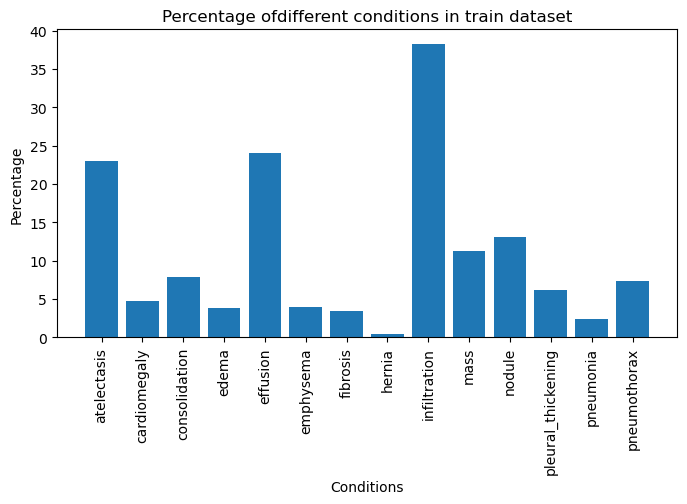

In [23]:
from matplotlib import pyplot as plt
plt.figure(figsize=(8,4))
plt.xticks(rotation = 90)
plt.bar(labels, train_dataset.labels.sum(axis = 0)/len(train_dataset) * 100)
plt.title('Percentage ofdifferent conditions in train dataset')
plt.xlabel('Conditions')
plt.ylabel('Percentage')
plt.show()

/tmp/ipykernel_28/1385432927.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v} for l,v in enumerate(freq_neg)], ignore_index=True)


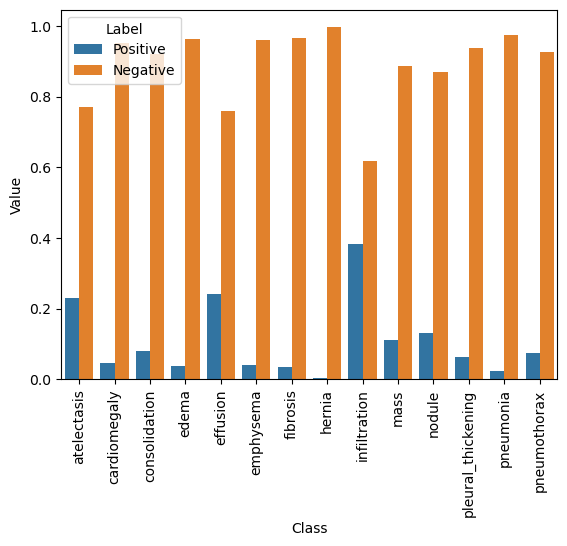

In [24]:
import seaborn as sns
def compute_class_freqs(labels):
    """
    Compute positive and negative frequences for each class.

    Args:
        labels (np.array): matrix of labels, size (num_examples, num_classes)
    Returns:
        positive_frequencies (np.array): array of positive frequences for each
                                         class, size (num_classes)
        negative_frequencies (np.array): array of negative frequences for each
                                         class, size (num_classes)
    """    
    # total number of patients (rows)
    N = labels.shape[0]
    positive_frequencies = (labels.sum(axis = 0))/N
    negative_frequencies = 1.0 - positive_frequencies
    
    return positive_frequencies, negative_frequencies


# calulating and plotting the imbalanced classes
freq_pos, freq_neg = compute_class_freqs(train_dataset.labels)
data = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": freq_pos})
data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v} for l,v in enumerate(freq_neg)], ignore_index=True)
plt.xticks(rotation=90)
f = sns.barplot(x="Class", y="Value", hue="Label" ,data=data)

/tmp/ipykernel_28/1490179493.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v}


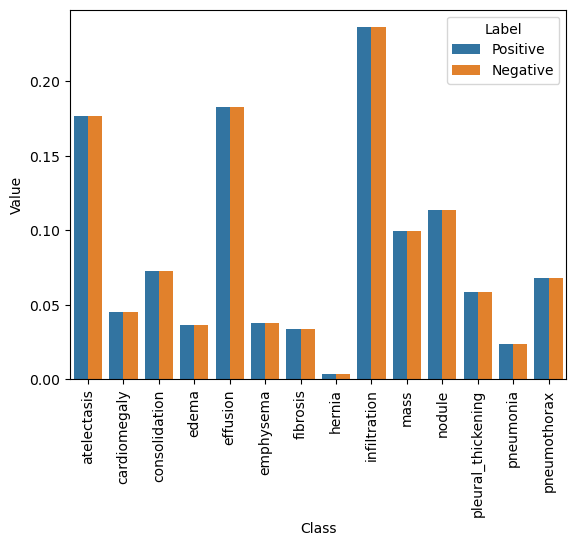

In [25]:
pos_weights = freq_neg
neg_weights = freq_pos
pos_contribution = freq_pos * pos_weights 
neg_contribution = freq_neg * neg_weights
pos_weights


data = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": pos_contribution})
data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v} 
                        for l,v in enumerate(neg_contribution)], ignore_index=True)
plt.xticks(rotation=90)
sns.barplot(x="Class", y="Value", hue="Label" ,data=data);

In [26]:
class WeightedLoss(nn.Module):
    def __init__(self):
        super(WeightedLoss, self).__init__()

    def forward(self, y_pred, y_true):
#         y_true = torch.LongTensor(y_true)
        loss = 0.0
        epsilon = 1e-9
        for i in range(len(pos_weights)):
            # for each class, add average weighted loss for that class 
            loss_pos = -1 * torch.mean(pos_weights[i] * y_true[:, i] * torch.log(y_pred[:, i] + epsilon))
            loss_neg = -1 * torch.mean(neg_weights[i] * (1 - y_true[:, i]) * torch.log(1 - y_pred[:, i] + epsilon))
            loss += loss_pos + loss_neg
        return loss

In [27]:
# cr = WeightedLoss()
# cr(torch.tensor([[1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0], 
#                  [0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1]]),
#    torch.tensor([[1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0],
#                  [0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1]]))

In [28]:
import random

from torch.utils.data.sampler import Sampler


class MultilabelBalancedRandomSampler(Sampler):
    """
    MultilabelBalancedRandomSampler: Given a multilabel dataset of length n_samples and
    number of classes n_classes, samples from the data with equal probability per class
    effectively oversampling minority classes and undersampling majority classes at the
    same time. Note that using this sampler does not guarantee that the distribution of
    classes in the output samples will be uniform, since the dataset is multilabel and
    sampling is based on a single class. This does however guarantee that all classes
    will have at least batch_size / n_classes samples as batch_size approaches infinity
    """

    def __init__(self, labels, indices=None, class_choice="least_sampled"):
        """
        Parameters:
        -----------
            labels: a multi-hot encoding numpy array of shape (n_samples, n_classes)
            indices: an arbitrary-length 1-dimensional numpy array representing a list
            of indices to sample only from
            class_choice: a string indicating how class will be selected for every
            sample:
                "least_sampled": class with the least number of sampled labels so far
                "random": class is chosen uniformly at random
                "cycle": the sampler cycles through the classes sequentially
        """
        self.labels = labels
        self.indices = indices
        # print(self.labels)
        if self.indices is None:
            self.indices = range(len(labels))

        self.num_classes = self.labels.shape[1]

        # List of lists of example indices per class
        self.class_indices = []
        for class_ in range(self.num_classes):
            lst = np.where(self.labels[:, class_] == 1)[0]
            lst = lst[np.isin(lst, self.indices)]
            self.class_indices.append(lst)

        self.counts = [0] * self.num_classes
        # print(self.counts)
        assert class_choice in ["least_sampled", "random", "cycle"]
        self.class_choice = class_choice
        self.current_class = 0
        # print(self.class_indices)

    def __iter__(self):
        self.count = 0
        return self

    def __next__(self):
        if self.count >= len(self.indices):
            raise StopIteration
        self.count += 1
        return self.sample()

    def sample(self):
        class_ = self.get_class()
        class_indices = self.class_indices[class_]
        chosen_index = np.random.choice(class_indices)
        if self.class_choice == "least_sampled":
            for class_, indicator in enumerate(self.labels[chosen_index]):
                if indicator == 1:
                    self.counts[class_] += 1
        return chosen_index

    def get_class(self):
        if self.class_choice == "random":
            class_ = random.randint(0, self.labels.shape[1] - 1)
        elif self.class_choice == "cycle":
            class_ = self.current_class
            self.current_class = (self.current_class + 1) % self.labels.shape[1]
        elif self.class_choice == "least_sampled":
            min_count = self.counts[0]
            min_classes = [0]
            for class_ in range(1, self.num_classes):
                if self.counts[class_] < min_count:
                    min_count = self.counts[class_]
                    min_classes = [class_]
                if self.counts[class_] == min_count:
                    min_classes.append(class_)
            class_ = np.random.choice(min_classes)
        return class_

    def __len__(self):
        return len(self.indices)

# Function that returns balanced accuracies, recall and precision

In [29]:
from sklearn.metrics import balanced_accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=UserWarning)
from sklearn.metrics import precision_score, recall_score

def get_classes_accuracy_and_pr(loader, model):
    model.eval()
    total_balanced_acc = []
    precision_scores = []
    recall_scores = []
    f1_scores = []
    
    y_true = []
    y_pred = []
    
    for images, labels in tqdm(loader):
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        outputs = nn.Sigmoid()(model(images)).to(DEVICE)
        batch_balanced_accuracies = []

        np_labels = labels.cpu().detach().numpy()
        np_outputs = outputs.cpu().detach().numpy()
        for k in range(len(np_outputs)):
            for j in range(len(np_outputs[k])):
                np_outputs[k][j] = 1 if np_outputs[k][j] > THRESHOLD else 0

        y_true.extend(list(np_labels))
        y_pred.extend(list(np_outputs))
        
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    for i in range(len(outputs[0])):
        bal_acc = balanced_accuracy_score(y_true[:, i], y_pred[:, i])
        total_balanced_acc.append(bal_acc)
        
        precision = precision_score(y_true[:, i], y_pred[:, i])
        precision_scores.append(precision)
        
        recall = recall_score(y_true[:, i], y_pred[:, i])
        recall_scores.append(recall)
        
        f1 = f1_score(y_true[:, i], y_pred[:, i])
        f1_scores.append(f1)
        
#         cm = confusion_matrix(y_true[:, i], y_pred[:, i], labels=mlb.classes)
#         disp = ConfusionMatrixDisplay(confusion_matrix=cm,
#                                       display_labels=mlb.classes)
#         disp.plot()
            
#             bal_acc = balanced_accuracy_score(np_labels[:, i], np_outputs[:, i])
#             batch_balanced_accuracies.append(bal_acc)
#         total_balanced_acc.append(batch_balanced_accuracies)
    
#     mean_acc = np.mean(total_balanced_acc, axis=0)
#     print(len(total_balanced_acc))
#     print(mean_acc)
    return total_balanced_acc, precision_scores, recall_scores, f1_scores

In [30]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
# DEVICE = 'cpu'

BATCH_SIZE = 32
LEARNING_RATE = 1e-6
PIN_MEMORY = False
EPOCHS = 10
THRESHOLD = 0.5

In [31]:
print(DEVICE)

cuda


In [32]:
test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=int(BATCH_SIZE/2),
    pin_memory=PIN_MEMORY,
    shuffle=False,
)

In [33]:
def train_epoch(loader, model, optimizer, loss_fn, epoch):
    model.train()
    
    losses = []
    i = 0
    running_loss = 0.
    for images, labels, in tqdm(loader):
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        
        outputs = nn.Sigmoid()(model(images)).to(DEVICE)
        loss = loss_fn(outputs, labels)
        losses.append(loss.item())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        if i % 200 == 199:
            last_loss = running_loss / 200 # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            running_loss = 0.
        i += 1
        
    print(f'=> Epoch[{epoch}]: Mean Loss = {np.mean(losses)}')
    torch.save(model.state_dict(), f'./weighted_bce_loss_weights{epoch}.pt')
    
    return np.mean(losses)

# Removing rare disease

In [34]:
labels = ['atelectasis', 'consolidation', 
          'effusion', 'infiltration','mass', 'nodule', 'pneumothorax']

In [35]:
cols_to_drop = ['Hernia', 'Pneumonia', 'Cardiomegaly', 'Fibrosis', 'Edema', 'Emphysema', 'Pleural_Thickening']
stripped_df = final_df.drop(columns=cols_to_drop)

In [36]:
stripped_df

,Image,Atelectasis,Consolidation,Effusion,Infiltration,Mass,Nodule,Pneumothorax
0,00000001_000.png,0,0,0,0,0,0,0
1,00000001_001.png,0,0,0,0,0,0,0
2,00000001_002.png,0,0,1,0,0,0,0
3,00000003_000.png,0,0,0,0,0,0,0
4,00000003_001.png,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
51703,00030786_007.png,0,1,0,0,0,0,0
51704,00030789_000.png,0,0,0,1,0,0,0
51705,00030793_000.png,0,0,0,0,1,1,0
51706,00030795_000.png,0,0,0,0,0,0,0


In [37]:
train_dataset = ChestXRayDataset(
    root='/kaggle/input/nih-chest-x-ray-14-224x224-resized/train_val_list_NIH.txt',
    df=stripped_df,
    transform=basic_transform
)

test_dataset = ChestXRayDataset(
    root='/kaggle/input/nih-chest-x-ray-14-224x224-resized/test_list_NIH.txt',
    df=stripped_df,
    transform=basic_transform
)

In [38]:
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    pin_memory=PIN_MEMORY,
    sampler=MultilabelBalancedRandomSampler(train_dataset.labels),
    drop_last=False,
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=int(BATCH_SIZE/2),
    pin_memory=PIN_MEMORY,
    shuffle=False,
)

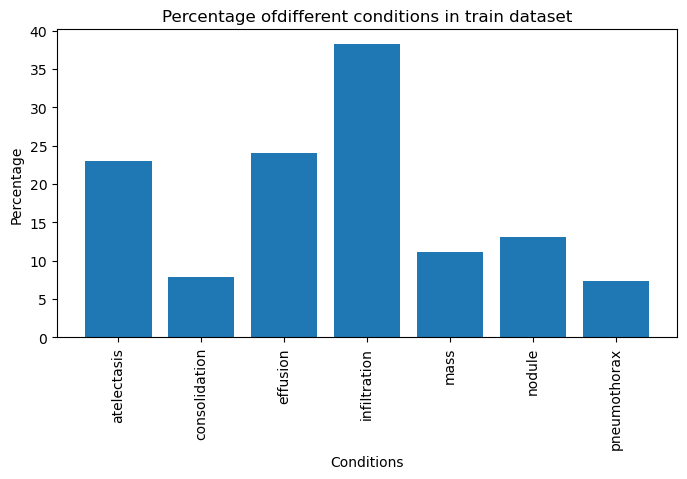

In [39]:
from matplotlib import pyplot as plt
plt.figure(figsize=(8,4))
plt.xticks(rotation = 90)
plt.bar(labels, train_dataset.labels.sum(axis = 0)/len(train_dataset) * 100)
plt.title('Percentage ofdifferent conditions in train dataset')
plt.xlabel('Conditions')
plt.ylabel('Percentage')
plt.show()

/tmp/ipykernel_28/1385432927.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v} for l,v in enumerate(freq_neg)], ignore_index=True)


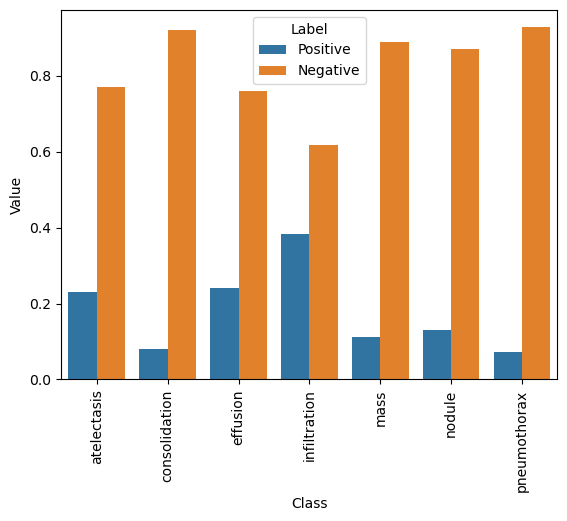

In [40]:
import seaborn as sns
def compute_class_freqs(labels):
    """
    Compute positive and negative frequences for each class.

    Args:
        labels (np.array): matrix of labels, size (num_examples, num_classes)
    Returns:
        positive_frequencies (np.array): array of positive frequences for each
                                         class, size (num_classes)
        negative_frequencies (np.array): array of negative frequences for each
                                         class, size (num_classes)
    """    
    # total number of patients (rows)
    N = labels.shape[0]
    positive_frequencies = (labels.sum(axis = 0))/N
    negative_frequencies = 1.0 - positive_frequencies
    
    return positive_frequencies, negative_frequencies


# calulating and plotting the imbalanced classes
freq_pos, freq_neg = compute_class_freqs(train_dataset.labels)
data = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": freq_pos})
data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v} for l,v in enumerate(freq_neg)], ignore_index=True)
plt.xticks(rotation=90)
f = sns.barplot(x="Class", y="Value", hue="Label" ,data=data)

/tmp/ipykernel_28/1490179493.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v}


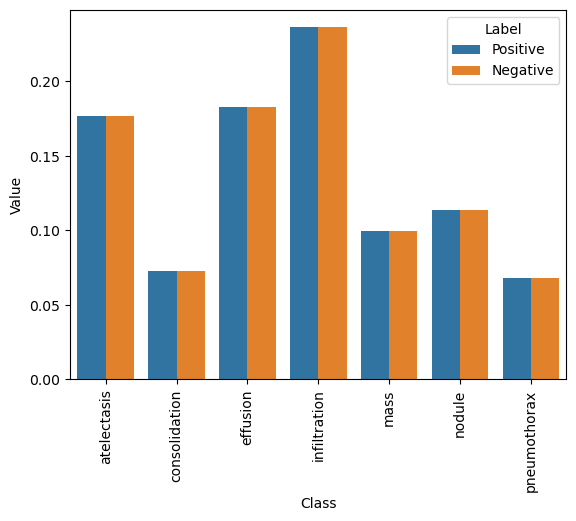

In [41]:
pos_weights = freq_neg
neg_weights = freq_pos
pos_contribution = freq_pos * pos_weights 
neg_contribution = freq_neg * neg_weights
pos_weights


data = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": pos_contribution})
data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v} 
                        for l,v in enumerate(neg_contribution)], ignore_index=True)
plt.xticks(rotation=90)
sns.barplot(x="Class", y="Value", hue="Label" ,data=data);

In [42]:
class WeightedLoss(nn.Module):
    def __init__(self):
        super(WeightedLoss, self).__init__()

    def forward(self, y_pred, y_true):
#         y_true = torch.LongTensor(y_true)
        loss = 0.0
        epsilon = 1e-9
        for i in range(len(pos_weights)):
            # for each class, add average weighted loss for that class 
            loss_pos = -1 * torch.mean(pos_weights[i] * y_true[:, i] * torch.log(y_pred[:, i] + epsilon))
            loss_neg = -1 * torch.mean(neg_weights[i] * (1 - y_true[:, i]) * torch.log(1 - y_pred[:, i] + epsilon))
            loss += (loss_pos + loss_neg)
        return loss

# Training ensemble of DenseNet121

In [43]:
class WeightedLoss(nn.Module):
    def __init__(self, pos_weights, neg_weights):
        super(WeightedLoss, self).__init__()
        self.pos_weights = pos_weights
        self.neg_weights = neg_weights

    def forward(self, y_pred, y_true):
#         y_true = torch.LongTensor(y_true)
        loss = 0.0
        epsilon = 1e-9
        for i in range(len(pos_weights)):
            # for each class, add average weighted loss for that class 
            loss_pos = -1 * torch.mean(self.pos_weights[i] * y_true[:, i] * torch.log(y_pred[:, i] + epsilon))
            loss_neg = -1 * torch.mean(self.neg_weights[i] * (1 - y_true[:, i]) * torch.log(1 - y_pred[:, i] + epsilon))
            loss += (loss_pos + loss_neg)
        return loss

In [45]:
def get_predictions_and_labels(loader, model):
    model.eval()
    total_balanced_acc = []
    precision_scores = []
    recall_scores = []
    f1_scores = []
    
    y_true = []
    y_pred = []
    y_probs = []
    
    for images, labels in tqdm(loader):
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        outputs = nn.Sigmoid()(model(images)).to(DEVICE)
        batch_balanced_accuracies = []

        np_labels = labels.cpu().detach().numpy()
        np_outputs = outputs.cpu().detach().numpy()
        y_probs.extend(list(np_outputs.copy()))
        
        for k in range(len(np_outputs)):
            for j in range(len(np_outputs[k])):
                np_outputs[k][j] = 1 if np_outputs[k][j] > THRESHOLD else 0

        y_true.extend(list(np_labels))
        y_pred.extend(list(np_outputs))
        
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_probs = np.array(y_probs)
    
    return y_true, y_pred, y_probs

In [46]:
# inc = torchvision.models.inception_v3(pretrained=True)
# inc.AuxLogits.fc = nn.Linear(in_features=768, out_features=1, bias=True)
# inc.fc = nn.Linear(in_features=2048, out_features=1, bias=True)
# inc.to(DEVICE)

In [47]:
# densenet = torchvision.models.densenet121(pretrained=True)
# densenet.classifier = nn.Linear(in_features=1024, out_features=1, bias=True)
# densenet.to(DEVICE)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 244MB/s]


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [48]:
columns = stripped_df.columns

In [49]:
loss_weights = [3.39, 13.2, 3.34, 1.63, 9, 11.5, 24]

In [51]:
accs = []
bal_accs = []
f1_scores = []
precs = []
recs = []

for i in range(7):
    cur_accs = []
    cur_bal_accs = []
    cur_f1 = []
    cur_precs = []
    cur_recs = []
    
    cur_df = stripped_df[[columns[0], columns[i + 1]]]
    
    densenet = torchvision.models.densenet121(pretrained=True)
    densenet.classifier = nn.Linear(in_features=1024, out_features=1, bias=True)
    densenet.to(DEVICE)
    
    train_dataset = ChestXRayDataset(
    root='/kaggle/input/nih-chest-x-ray-14-224x224-resized/train_val_list_NIH.txt',
    df=cur_df,
    transform=basic_transform
    )
 
    test_dataset = ChestXRayDataset(
    root='/kaggle/input/nih-chest-x-ray-14-224x224-resized/test_list_NIH.txt',
    df=cur_df,
    transform=basic_transform
    )
    
    
    train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    pin_memory=PIN_MEMORY,
    shuffle = True,
    drop_last=False,
    )

    test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=int(BATCH_SIZE/2),
    pin_memory=PIN_MEMORY,
    shuffle=False,
    )
    
    freq_pos, freq_neg = compute_class_freqs(train_dataset.labels)
    pos_weights = freq_neg
    neg_weights = freq_pos
    
    optimizer = optim.Adam(densenet.parameters(), lr=1e-6)
    scheduler = optim.lr_scheduler.StepLR(optimizer, 3, gamma=0.1)
#     loss_fn = nn.BCELoss()
#     loss_fn = WeightedLoss(pos_weights, [item * 1.3 for item in neg_weights])
    loss_fn = WeightedLoss([loss_weights[i]], [1])
    
    
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, balanced_accuracy_score

    with torch.no_grad():
        y_true, y_pred, y_probs = get_predictions_and_labels(test_loader, densenet)
        
        print(f'{columns[i + 1]} results')
        
        acc = accuracy_score(y_true, y_pred)
        cur_accs.append(acc)
        print(f'accuracy: {acc}\n')
        
        bal_acc = balanced_accuracy_score(y_true, y_pred)
        cur_bal_accs.append(bal_acc)
        print(f'balanced accuracy: {bal_acc}\n')
        
        prec = precision_score(y_true, y_pred)
        cur_precs.append(prec)
        print(f'precision: {prec}\n')
        
        rec = recall_score(y_true, y_pred)
        cur_recs.append(rec)
        print(f'recall: {rec}\n')

        f1 = f1_score(y_true, y_pred)
        cur_f1.append(f1)
        print(f'f1: {f1}\n')
        
    
    for epoch in range(8):
        loss = train_epoch(
            train_loader,
            densenet,
            optimizer,
            loss_fn,
            epoch + 1
        )
    
        with torch.no_grad():
            y_true, y_pred, y_probs = get_predictions_and_labels(test_loader, densenet)

            acc = accuracy_score(y_true, y_pred)
            cur_accs.append(acc)
            print(f'accuracy: {acc}\n')

            bal_acc = balanced_accuracy_score(y_true, y_pred)
            cur_bal_accs.append(bal_acc)
            print(f'balanced accuracy: {bal_acc}\n')

            prec = precision_score(y_true, y_pred)
            cur_precs.append(prec)
            print(f'precision: {prec}\n')

            rec = recall_score(y_true, y_pred)
            cur_recs.append(rec)
            print(f'recall: {rec}\n')

            f1 = f1_score(y_true, y_pred)
            cur_f1.append(f1)
            print(f'f1: {f1}\n')

    accs.append(cur_accs)
    bal_accs.append(cur_bal_accs)
    f1_scores.append(cur_f1)
    precs.append(cur_precs)
    recs.append(cur_recs)

100%|██████████| 981/981 [01:57<00:00,  8.35it/s]


Atelectasis results
accuracy: 0.20849273144605968

balanced accuracy: 0.49980975813588924

precision: 0.20747365059086553

recall: 0.9978494623655914

f1: 0.3435219460602855



 18%|█▊        | 200/1126 [01:26<06:33,  2.36it/s]

  batch 200 loss: 1.0780443686246872


 36%|███▌      | 400/1126 [02:51<05:10,  2.34it/s]

  batch 400 loss: 1.0558106303215027


 53%|█████▎    | 600/1126 [04:17<03:45,  2.34it/s]

  batch 600 loss: 1.0676611799001694


 71%|███████   | 800/1126 [05:42<02:17,  2.38it/s]

  batch 800 loss: 1.0545261490345001


 89%|████████▉ | 1000/1126 [07:08<00:55,  2.29it/s]

  batch 1000 loss: 1.0329880261421203


100%|██████████| 1126/1126 [08:02<00:00,  2.33it/s]


=> Epoch[1]: Mean Loss = 1.055236672476384


100%|██████████| 981/981 [01:59<00:00,  8.18it/s]


accuracy: 0.4503315480744708

balanced accuracy: 0.5555687920290475

precision: 0.23576915501280285

recall: 0.7354838709677419

f1: 0.3570736072786934



 18%|█▊        | 200/1126 [01:25<06:44,  2.29it/s]

  batch 200 loss: 1.0120350745320321


 36%|███▌      | 400/1126 [02:50<05:06,  2.37it/s]

  batch 400 loss: 1.0121675997972488


 53%|█████▎    | 600/1126 [04:15<03:41,  2.37it/s]

  batch 600 loss: 1.0118451711535454


 71%|███████   | 800/1126 [05:40<02:16,  2.38it/s]

  batch 800 loss: 1.0148255550861358


 89%|████████▉ | 1000/1126 [07:10<01:03,  1.98it/s]

  batch 1000 loss: 1.0070683965086937


100%|██████████| 1126/1126 [08:06<00:00,  2.32it/s]


=> Epoch[2]: Mean Loss = 1.0106190390104086


100%|██████████| 981/981 [01:53<00:00,  8.63it/s]


accuracy: 0.5450777862790105

balanced accuracy: 0.5909713532310529

precision: 0.26450594804564215

recall: 0.669431643625192

f1: 0.3791873314191247



 18%|█▊        | 200/1126 [01:30<06:36,  2.33it/s]

  batch 200 loss: 0.9912947210669517


 36%|███▌      | 400/1126 [02:55<05:04,  2.39it/s]

  batch 400 loss: 0.9871486723423004


 53%|█████▎    | 600/1126 [04:20<03:41,  2.37it/s]

  batch 600 loss: 0.973315415084362


 71%|███████   | 800/1126 [05:45<02:16,  2.38it/s]

  batch 800 loss: 0.9666828548908234


 89%|████████▉ | 1000/1126 [07:11<01:01,  2.06it/s]

  batch 1000 loss: 0.9747093224525452


100%|██████████| 1126/1126 [08:04<00:00,  2.32it/s]


=> Epoch[3]: Mean Loss = 0.97940733208326


100%|██████████| 981/981 [01:52<00:00,  8.70it/s]


accuracy: 0.6085819943891865

balanced accuracy: 0.6206078544566316

precision: 0.29569283083026354

recall: 0.6411674347158218

f1: 0.40473189178706487



 18%|█▊        | 200/1126 [01:24<06:27,  2.39it/s]

  batch 200 loss: 0.9556703987717629


 36%|███▌      | 400/1126 [02:49<05:04,  2.39it/s]

  batch 400 loss: 0.9615006437897682


 53%|█████▎    | 600/1126 [04:14<03:44,  2.34it/s]

  batch 600 loss: 0.9708556750416756


 71%|███████   | 800/1126 [05:40<02:21,  2.31it/s]

  batch 800 loss: 0.9499205240607261


 89%|████████▉ | 1000/1126 [07:05<00:53,  2.35it/s]

  batch 1000 loss: 0.9434250855445862


100%|██████████| 1126/1126 [07:59<00:00,  2.35it/s]


=> Epoch[4]: Mean Loss = 0.9524856944490707


100%|██████████| 981/981 [01:52<00:00,  8.69it/s]


accuracy: 0.6273272124458047

balanced accuracy: 0.6323216514966299

precision: 0.3084886128364389

recall: 0.6408602150537634

f1: 0.416491963661775



 18%|█▊        | 200/1126 [01:27<06:29,  2.37it/s]

  batch 200 loss: 0.9269359377026558


 36%|███▌      | 400/1126 [02:58<05:08,  2.36it/s]

  batch 400 loss: 0.9320959201455117


 53%|█████▎    | 600/1126 [04:29<04:53,  1.79it/s]

  batch 600 loss: 0.9291986763477326


 71%|███████   | 800/1126 [05:56<02:18,  2.36it/s]

  batch 800 loss: 0.9289890891313553


 89%|████████▉ | 1000/1126 [07:21<00:53,  2.35it/s]

  batch 1000 loss: 0.9276380556821823


100%|██████████| 1126/1126 [08:15<00:00,  2.27it/s]


=> Epoch[5]: Mean Loss = 0.9303594801713899


100%|██████████| 981/981 [01:55<00:00,  8.49it/s]


accuracy: 0.6404616169344555

balanced accuracy: 0.640948866056899

precision: 0.3183480646144468

recall: 0.6417818740399386

f1: 0.425588265254151



 18%|█▊        | 200/1126 [01:25<06:33,  2.35it/s]

  batch 200 loss: 0.9133747056126594


 36%|███▌      | 400/1126 [02:51<05:07,  2.36it/s]

  batch 400 loss: 0.924657951593399


 53%|█████▎    | 600/1126 [04:17<03:49,  2.29it/s]

  batch 600 loss: 0.9116679194569588


 71%|███████   | 800/1126 [05:43<02:18,  2.35it/s]

  batch 800 loss: 0.9101197251677513


 89%|████████▉ | 1000/1126 [07:09<00:55,  2.26it/s]

  batch 1000 loss: 0.9011296445131302


100%|██████████| 1126/1126 [08:03<00:00,  2.33it/s]


=> Epoch[6]: Mean Loss = 0.9099651803237718


100%|██████████| 981/981 [01:53<00:00,  8.65it/s]


accuracy: 0.6549987248150982

balanced accuracy: 0.6456990915774874

precision: 0.32768542199488493

recall: 0.6298003072196621

f1: 0.43107980233413945



 18%|█▊        | 200/1126 [01:28<07:57,  1.94it/s]

  batch 200 loss: 0.9141638424992561


 36%|███▌      | 400/1126 [02:57<05:06,  2.37it/s]

  batch 400 loss: 0.9185686856508255


 53%|█████▎    | 600/1126 [04:26<04:17,  2.04it/s]

  batch 600 loss: 0.8726000559329986


 71%|███████   | 800/1126 [05:54<02:43,  2.00it/s]

  batch 800 loss: 0.8818054351210595


 89%|████████▉ | 1000/1126 [07:22<00:59,  2.12it/s]

  batch 1000 loss: 0.8938625046610832


100%|██████████| 1126/1126 [08:19<00:00,  2.26it/s]


=> Epoch[7]: Mean Loss = 0.896294921795386


100%|██████████| 981/981 [01:58<00:00,  8.30it/s]


accuracy: 0.6750191277735271

balanced accuracy: 0.648126519923488

precision: 0.34015966678236725

recall: 0.6021505376344086

f1: 0.43473439059554175



 18%|█▊        | 200/1126 [01:25<06:40,  2.31it/s]

  batch 200 loss: 0.8825365355610848


 36%|███▌      | 400/1126 [02:50<05:05,  2.37it/s]

  batch 400 loss: 0.860817479789257


 53%|█████▎    | 600/1126 [04:16<03:42,  2.36it/s]

  batch 600 loss: 0.8868170452117919


 71%|███████   | 800/1126 [05:41<02:17,  2.36it/s]

  batch 800 loss: 0.8839841079711914


 89%|████████▉ | 1000/1126 [07:06<00:53,  2.37it/s]

  batch 1000 loss: 0.8814415249228478


100%|██████████| 1126/1126 [08:00<00:00,  2.35it/s]


=> Epoch[8]: Mean Loss = 0.8793990307125275


100%|██████████| 981/981 [01:52<00:00,  8.69it/s]


accuracy: 0.6734251466462637

balanced accuracy: 0.6538103061333073

precision: 0.34191363251481793

recall: 0.6202764976958526

f1: 0.44082969432314406



100%|██████████| 981/981 [01:54<00:00,  8.54it/s]


Consolidation results
accuracy: 0.8441086457536343

balanced accuracy: 0.4904561513906095

precision: 0.07432432432432433

recall: 0.030303030303030304

f1: 0.043052837573385516



 18%|█▊        | 200/1126 [01:25<06:37,  2.33it/s]

  batch 200 loss: 1.3924176961183548


 36%|███▌      | 400/1126 [02:50<05:09,  2.35it/s]

  batch 400 loss: 1.3205649214982986


 53%|█████▎    | 600/1126 [04:16<03:44,  2.34it/s]

  batch 600 loss: 1.3535842701792717


 71%|███████   | 800/1126 [05:41<02:21,  2.31it/s]

  batch 800 loss: 1.3649274936318398


 89%|████████▉ | 1000/1126 [07:10<01:10,  1.78it/s]

  batch 1000 loss: 1.2818210160732268


100%|██████████| 1126/1126 [08:08<00:00,  2.31it/s]


=> Epoch[1]: Mean Loss = 1.334408415464906


100%|██████████| 981/981 [01:54<00:00,  8.59it/s]


accuracy: 0.4538383065544504

balanced accuracy: 0.5966067375423756

precision: 0.14805546866854344

recall: 0.7823691460055097

f1: 0.2489917587234789



 18%|█▊        | 200/1126 [01:25<06:30,  2.37it/s]

  batch 200 loss: 1.2885147848725318


 36%|███▌      | 400/1126 [02:50<05:05,  2.38it/s]

  batch 400 loss: 1.2877875027060508


 53%|█████▎    | 600/1126 [04:18<05:06,  1.72it/s]

  batch 600 loss: 1.2798527669906616


 71%|███████   | 800/1126 [05:53<03:08,  1.73it/s]

  batch 800 loss: 1.2318761575222015


 89%|████████▉ | 1000/1126 [07:29<01:09,  1.82it/s]

  batch 1000 loss: 1.2571502459049224


100%|██████████| 1126/1126 [08:29<00:00,  2.21it/s]


=> Epoch[2]: Mean Loss = 1.2742724392702058


100%|██████████| 981/981 [02:00<00:00,  8.13it/s]


accuracy: 0.39734761540423363

balanced accuracy: 0.5919600702917321

precision: 0.14329752452125175

recall: 0.8451790633608816

f1: 0.2450479233226837



 18%|█▊        | 200/1126 [01:25<06:36,  2.34it/s]

  batch 200 loss: 1.277623019516468


 36%|███▌      | 400/1126 [02:51<05:21,  2.26it/s]

  batch 400 loss: 1.219410809278488


 53%|█████▎    | 600/1126 [04:16<03:42,  2.37it/s]

  batch 600 loss: 1.2693534716963768


 71%|███████   | 800/1126 [05:42<02:19,  2.34it/s]

  batch 800 loss: 1.261822896897793


 89%|████████▉ | 1000/1126 [07:08<00:54,  2.30it/s]

  batch 1000 loss: 1.2364772588014603


100%|██████████| 1126/1126 [08:01<00:00,  2.34it/s]


=> Epoch[3]: Mean Loss = 1.250835165407899


100%|██████████| 981/981 [01:53<00:00,  8.65it/s]


accuracy: 0.3968375414435093

balanced accuracy: 0.5950236838326036

precision: 0.14412065915650313

recall: 0.8528925619834711

f1: 0.24657534246575344



 18%|█▊        | 200/1126 [01:25<06:33,  2.36it/s]

  batch 200 loss: 1.2419128087162972


 36%|███▌      | 400/1126 [02:50<05:06,  2.37it/s]

  batch 400 loss: 1.2063669222593307


 53%|█████▎    | 600/1126 [04:16<03:43,  2.36it/s]

  batch 600 loss: 1.2174741810560226


 71%|███████   | 800/1126 [05:43<02:19,  2.35it/s]

  batch 800 loss: 1.24648224234581


 89%|████████▉ | 1000/1126 [07:08<00:53,  2.36it/s]

  batch 1000 loss: 1.2173384746909142


100%|██████████| 1126/1126 [08:02<00:00,  2.34it/s]


=> Epoch[4]: Mean Loss = 1.2319289198141963


100%|██████████| 981/981 [01:53<00:00,  8.66it/s]


accuracy: 0.3886125988268299

balanced accuracy: 0.5925278982974694

precision: 0.14300146950771492

recall: 0.8578512396694215

f1: 0.24513894355664018



 18%|█▊        | 200/1126 [01:25<06:39,  2.32it/s]

  batch 200 loss: 1.1982572960853577


 36%|███▌      | 400/1126 [02:51<05:05,  2.37it/s]

  batch 400 loss: 1.2027322992682457


 53%|█████▎    | 600/1126 [04:20<03:44,  2.34it/s]

  batch 600 loss: 1.1988743737339973


 71%|███████   | 800/1126 [05:46<02:19,  2.33it/s]

  batch 800 loss: 1.2137196570634843


 89%|████████▉ | 1000/1126 [07:12<00:54,  2.32it/s]

  batch 1000 loss: 1.2556288662552832


100%|██████████| 1126/1126 [08:06<00:00,  2.32it/s]


=> Epoch[5]: Mean Loss = 1.2155246599635265


100%|██████████| 981/981 [01:54<00:00,  8.58it/s]


accuracy: 0.3867635807192043

balanced accuracy: 0.5912429706778123

precision: 0.14255611543747138

recall: 0.8573002754820936

f1: 0.24446190102120974



 18%|█▊        | 200/1126 [01:25<06:30,  2.37it/s]

  batch 200 loss: 1.1914920508861542


 36%|███▌      | 400/1126 [02:51<05:20,  2.26it/s]

  batch 400 loss: 1.195370925962925


 53%|█████▎    | 600/1126 [04:19<03:54,  2.24it/s]

  batch 600 loss: 1.2030775693058968


 71%|███████   | 800/1126 [05:49<02:26,  2.22it/s]

  batch 800 loss: 1.182286942601204


 89%|████████▉ | 1000/1126 [07:20<01:01,  2.06it/s]

  batch 1000 loss: 1.2131845632195473


100%|██████████| 1126/1126 [08:17<00:00,  2.26it/s]


=> Epoch[6]: Mean Loss = 1.2005431040142187


100%|██████████| 981/981 [02:06<00:00,  7.78it/s]


accuracy: 0.39422341239479725

balanced accuracy: 0.5935455671695422

precision: 0.14357262103505844

recall: 0.8528925619834711

f1: 0.24577280304834484



 18%|█▊        | 200/1126 [01:27<06:51,  2.25it/s]

  batch 200 loss: 1.1443726032972337


 36%|███▌      | 400/1126 [02:54<05:16,  2.29it/s]

  batch 400 loss: 1.193764052093029


 53%|█████▎    | 600/1126 [04:22<03:56,  2.23it/s]

  batch 600 loss: 1.177814096212387


 71%|███████   | 800/1126 [05:51<02:26,  2.23it/s]

  batch 800 loss: 1.2371110171079636


 89%|████████▉ | 1000/1126 [07:22<00:55,  2.28it/s]

  batch 1000 loss: 1.1872750744223595


100%|██████████| 1126/1126 [08:18<00:00,  2.26it/s]


=> Epoch[7]: Mean Loss = 1.182649544511341


100%|██████████| 981/981 [01:53<00:00,  8.63it/s]


accuracy: 0.3659143075745983

balanced accuracy: 0.5871158639667873

precision: 0.1404563948346011

recall: 0.874931129476584

f1: 0.24205472143891468



 18%|█▊        | 200/1126 [01:25<06:31,  2.37it/s]

  batch 200 loss: 1.1495254004001618


 36%|███▌      | 400/1126 [02:50<05:06,  2.37it/s]

  batch 400 loss: 1.1527182140946388


 53%|█████▎    | 600/1126 [04:16<03:48,  2.30it/s]

  batch 600 loss: 1.175077588558197


 71%|███████   | 800/1126 [05:41<02:17,  2.37it/s]

  batch 800 loss: 1.160734149515629


 89%|████████▉ | 1000/1126 [07:07<00:54,  2.32it/s]

  batch 1000 loss: 1.2148997104167938


100%|██████████| 1126/1126 [08:01<00:00,  2.34it/s]


=> Epoch[8]: Mean Loss = 1.1679854705850354


100%|██████████| 981/981 [01:52<00:00,  8.69it/s]


accuracy: 0.35641418005610814

balanced accuracy: 0.5838990459130864

precision: 0.13919637409570296

recall: 0.8798898071625344

f1: 0.24036724864539433



100%|██████████| 981/981 [01:53<00:00,  8.63it/s]


Effusion results
accuracy: 0.47545269064014284

balanced accuracy: 0.5233418918775605

precision: 0.3123623781063227

recall: 0.64092082616179

f1: 0.42002114910116317



 18%|█▊        | 200/1126 [01:25<06:48,  2.27it/s]

  batch 200 loss: 1.0777329525351524


 36%|███▌      | 400/1126 [02:50<05:08,  2.36it/s]

  batch 400 loss: 1.0451971259713173


 53%|█████▎    | 600/1126 [04:16<03:44,  2.35it/s]

  batch 600 loss: 1.049000579714775


 71%|███████   | 800/1126 [05:42<02:20,  2.32it/s]

  batch 800 loss: 1.025923055112362


 89%|████████▉ | 1000/1126 [07:10<00:54,  2.29it/s]

  batch 1000 loss: 1.0214107754826545


100%|██████████| 1126/1126 [08:06<00:00,  2.31it/s]


=> Epoch[1]: Mean Loss = 1.0399512044066435


100%|██████████| 981/981 [01:58<00:00,  8.31it/s]


accuracy: 0.47277480234634023

balanced accuracy: 0.5834568403578587

precision: 0.34353124189784806

recall: 0.8552065404475043

f1: 0.49016585486158204



 18%|█▊        | 200/1126 [01:31<06:56,  2.23it/s]

  batch 200 loss: 0.9994556179642677


 36%|███▌      | 400/1126 [02:59<05:11,  2.33it/s]

  batch 400 loss: 0.9800389263033867


 53%|█████▎    | 600/1126 [04:28<03:47,  2.31it/s]

  batch 600 loss: 0.9716688045859336


 71%|███████   | 800/1126 [05:58<02:46,  1.96it/s]

  batch 800 loss: 0.9462770098447799


 89%|████████▉ | 1000/1126 [07:25<00:58,  2.17it/s]

  batch 1000 loss: 0.9369677951931954


100%|██████████| 1126/1126 [08:21<00:00,  2.25it/s]


=> Epoch[2]: Mean Loss = 0.963939614766021


100%|██████████| 981/981 [01:54<00:00,  8.55it/s]


accuracy: 0.48578168834481

balanced accuracy: 0.6028488208516768

precision: 0.3538869409048149

recall: 0.8902753872633391

f1: 0.5064561532341962



 18%|█▊        | 200/1126 [01:25<06:41,  2.30it/s]

  batch 200 loss: 0.9211631661653519


 36%|███▌      | 400/1126 [02:50<05:04,  2.38it/s]

  batch 400 loss: 0.9206952875852585


 53%|█████▎    | 600/1126 [04:20<04:05,  2.15it/s]

  batch 600 loss: 0.9019294476509094


 71%|███████   | 800/1126 [05:49<02:24,  2.26it/s]

  batch 800 loss: 0.9010780876874924


 89%|████████▉ | 1000/1126 [07:18<00:53,  2.36it/s]

  batch 1000 loss: 0.8889489763975144


100%|██████████| 1126/1126 [08:13<00:00,  2.28it/s]


=> Epoch[3]: Mean Loss = 0.9019676227235032


100%|██████████| 981/981 [01:53<00:00,  8.67it/s]


accuracy: 0.5521550624840602

balanced accuracy: 0.6378083399720146

precision: 0.38421052631578945

recall: 0.8481067125645438

f1: 0.5288435739200428



 18%|█▊        | 200/1126 [01:26<06:33,  2.36it/s]

  batch 200 loss: 0.8585431471467018


 36%|███▌      | 400/1126 [02:52<05:14,  2.31it/s]

  batch 400 loss: 0.8475573924183846


 53%|█████▎    | 600/1126 [04:17<03:44,  2.34it/s]

  batch 600 loss: 0.8603363978862762


 71%|███████   | 800/1126 [05:43<02:17,  2.38it/s]

  batch 800 loss: 0.8537213309109211


 89%|████████▉ | 1000/1126 [07:10<00:53,  2.37it/s]

  batch 1000 loss: 0.8782611158490181


100%|██████████| 1126/1126 [08:04<00:00,  2.32it/s]


=> Epoch[4]: Mean Loss = 0.858521882451237


100%|██████████| 981/981 [01:58<00:00,  8.29it/s]


accuracy: 0.5871588880387656

balanced accuracy: 0.6591945371711045

precision: 0.40483383685800606

recall: 0.8360585197934596

f1: 0.5455183547413491



 18%|█▊        | 200/1126 [01:25<06:34,  2.35it/s]

  batch 200 loss: 0.8250030440092087


 36%|███▌      | 400/1126 [03:11<06:24,  1.89it/s]

  batch 400 loss: 0.8378704446554184


 53%|█████▎    | 600/1126 [04:53<03:52,  2.27it/s]

  batch 600 loss: 0.8206263095140457


 71%|███████   | 800/1126 [06:31<02:19,  2.35it/s]

  batch 800 loss: 0.8309962052106857


 89%|████████▉ | 1000/1126 [08:08<00:58,  2.17it/s]

  batch 1000 loss: 0.821983072757721


100%|██████████| 1126/1126 [09:07<00:00,  2.05it/s]


=> Epoch[5]: Mean Loss = 0.8282488496646576


100%|██████████| 981/981 [01:58<00:00,  8.29it/s]


accuracy: 0.5964677378219841

balanced accuracy: 0.6654356513716024

precision: 0.4109734138332804

recall: 0.8347676419965576

f1: 0.5507842998083611



 18%|█▊        | 200/1126 [01:25<06:30,  2.37it/s]

  batch 200 loss: 0.8141299420595169


 36%|███▌      | 400/1126 [02:51<05:06,  2.37it/s]

  batch 400 loss: 0.8107979230582714


 53%|█████▎    | 600/1126 [04:16<03:44,  2.35it/s]

  batch 600 loss: 0.804416331499815


 71%|███████   | 800/1126 [05:41<02:17,  2.37it/s]

  batch 800 loss: 0.8273340398073197


 89%|████████▉ | 1000/1126 [07:07<00:53,  2.35it/s]

  batch 1000 loss: 0.7973954237997531


100%|██████████| 1126/1126 [08:01<00:00,  2.34it/s]


=> Epoch[6]: Mean Loss = 0.8082393029602128


100%|██████████| 981/981 [01:53<00:00,  8.61it/s]


accuracy: 0.6184646773782199

balanced accuracy: 0.6727225528219646

precision: 0.4243316719528772

recall: 0.8059380378657487

f1: 0.5559513208667259



 18%|█▊        | 200/1126 [01:25<06:30,  2.37it/s]

  batch 200 loss: 0.7935939601063728


 36%|███▌      | 400/1126 [02:50<05:09,  2.35it/s]

  batch 400 loss: 0.8046671757102013


 53%|█████▎    | 600/1126 [04:16<03:59,  2.19it/s]

  batch 600 loss: 0.7834456983208656


 71%|███████   | 800/1126 [05:41<02:17,  2.37it/s]

  batch 800 loss: 0.7847400864958763


 89%|████████▉ | 1000/1126 [07:07<00:53,  2.36it/s]

  batch 1000 loss: 0.7868095991015435


100%|██████████| 1126/1126 [08:00<00:00,  2.34it/s]


=> Epoch[7]: Mean Loss = 0.7902573123441919


100%|██████████| 981/981 [01:52<00:00,  8.70it/s]


accuracy: 0.621333843407294

balanced accuracy: 0.6775010776809927

precision: 0.42723481005523617

recall: 0.8154044750430293

f1: 0.5606923589022856



 18%|█▊        | 200/1126 [01:25<06:37,  2.33it/s]

  batch 200 loss: 0.7821824587881565


 36%|███▌      | 400/1126 [02:51<05:30,  2.20it/s]

  batch 400 loss: 0.7544840063154697


 53%|█████▎    | 600/1126 [04:16<03:42,  2.36it/s]

  batch 600 loss: 0.7885681566596031


 71%|███████   | 800/1126 [05:42<02:19,  2.33it/s]

  batch 800 loss: 0.7813974757492542


 89%|████████▉ | 1000/1126 [07:07<00:53,  2.36it/s]

  batch 1000 loss: 0.7709783081710339


100%|██████████| 1126/1126 [08:01<00:00,  2.34it/s]


=> Epoch[8]: Mean Loss = 0.7733942042659062


100%|██████████| 981/981 [01:55<00:00,  8.48it/s]


accuracy: 0.6494516704922214

balanced accuracy: 0.6869580403111957

precision: 0.4474789915966387

recall: 0.7790447504302926

f1: 0.5684458398744113



100%|██████████| 981/981 [01:53<00:00,  8.62it/s]


Infiltration results
accuracy: 0.44121397602652385

balanced accuracy: 0.4781698695634789

precision: 0.37269267364414843

recall: 0.6433968462549278

f1: 0.4719845764549946



 18%|█▊        | 200/1126 [01:25<06:31,  2.37it/s]

  batch 200 loss: 0.8656427082419396


 36%|███▌      | 400/1126 [02:52<05:36,  2.16it/s]

  batch 400 loss: 0.86925488114357


 53%|█████▎    | 600/1126 [04:23<03:52,  2.26it/s]

  batch 600 loss: 0.851392366886139


 71%|███████   | 800/1126 [05:50<02:17,  2.37it/s]

  batch 800 loss: 0.8577116018533707


 89%|████████▉ | 1000/1126 [07:15<00:53,  2.36it/s]

  batch 1000 loss: 0.845558590888977


100%|██████████| 1126/1126 [08:09<00:00,  2.30it/s]


=> Epoch[1]: Mean Loss = 0.856249772740088


100%|██████████| 981/981 [01:52<00:00,  8.69it/s]


accuracy: 0.5661820964039785

balanced accuracy: 0.5672954784598707

precision: 0.4534096824570536

recall: 0.5722733245729303

f1: 0.5059541097879755



 18%|█▊        | 200/1126 [01:25<06:32,  2.36it/s]

  batch 200 loss: 0.8383378446102142


 36%|███▌      | 400/1126 [02:50<05:08,  2.35it/s]

  batch 400 loss: 0.8343894726037979


 53%|█████▎    | 600/1126 [04:16<03:41,  2.37it/s]

  batch 600 loss: 0.8312709474563599


 71%|███████   | 800/1126 [05:41<02:18,  2.35it/s]

  batch 800 loss: 0.833893572986126


 89%|████████▉ | 1000/1126 [07:08<00:54,  2.30it/s]

  batch 1000 loss: 0.8358783081173897


100%|██████████| 1126/1126 [08:01<00:00,  2.34it/s]


=> Epoch[2]: Mean Loss = 0.8343169383215014


100%|██████████| 981/981 [01:53<00:00,  8.67it/s]


accuracy: 0.5495409334353482

balanced accuracy: 0.5784956664488434

precision: 0.44909867666979264

recall: 0.7079500657030223

f1: 0.5495696525342685



 18%|█▊        | 200/1126 [01:25<06:43,  2.30it/s]

  batch 200 loss: 0.824846088886261


 36%|███▌      | 400/1126 [02:50<05:10,  2.34it/s]

  batch 400 loss: 0.8251546373963357


 53%|█████▎    | 600/1126 [04:15<03:42,  2.37it/s]

  batch 600 loss: 0.8193463721871376


 71%|███████   | 800/1126 [05:41<02:18,  2.35it/s]

  batch 800 loss: 0.8214828076958657


 89%|████████▉ | 1000/1126 [07:06<00:52,  2.39it/s]

  batch 1000 loss: 0.8232749733328819


100%|██████████| 1126/1126 [08:00<00:00,  2.34it/s]


=> Epoch[3]: Mean Loss = 0.8230387795034988


100%|██████████| 981/981 [01:53<00:00,  8.68it/s]


accuracy: 0.5621652639632747

balanced accuracy: 0.5856599730286217

precision: 0.45761236260746546

recall: 0.6907030223390276

f1: 0.5505007527655953



 18%|█▊        | 200/1126 [01:27<06:30,  2.37it/s]

  batch 200 loss: 0.8171646538376808


 36%|███▌      | 400/1126 [02:57<05:08,  2.35it/s]

  batch 400 loss: 0.8185327237844467


 53%|█████▎    | 600/1126 [04:24<04:36,  1.90it/s]

  batch 600 loss: 0.8091642713546753


 71%|███████   | 800/1126 [05:51<02:20,  2.32it/s]

  batch 800 loss: 0.8122068849205971


 89%|████████▉ | 1000/1126 [07:17<00:53,  2.37it/s]

  batch 1000 loss: 0.8173754414916039


100%|██████████| 1126/1126 [08:11<00:00,  2.29it/s]


=> Epoch[4]: Mean Loss = 0.8137165628254519


100%|██████████| 981/981 [01:55<00:00,  8.51it/s]


accuracy: 0.563504208110176

balanced accuracy: 0.5894262912875985

precision: 0.45944789214637277

recall: 0.7053219448094612

f1: 0.5564338473500064



 18%|█▊        | 200/1126 [01:25<06:34,  2.35it/s]

  batch 200 loss: 0.8090480169653893


 36%|███▌      | 400/1126 [02:51<05:13,  2.31it/s]

  batch 400 loss: 0.8041603347659111


 53%|█████▎    | 600/1126 [04:16<03:43,  2.36it/s]

  batch 600 loss: 0.8067672455310821


 71%|███████   | 800/1126 [05:42<02:17,  2.37it/s]

  batch 800 loss: 0.8064217004179954


 89%|████████▉ | 1000/1126 [07:07<00:53,  2.37it/s]

  batch 1000 loss: 0.8055798608064652


100%|██████████| 1126/1126 [08:03<00:00,  2.33it/s]


=> Epoch[5]: Mean Loss = 0.8056504032433985


100%|██████████| 981/981 [02:07<00:00,  7.68it/s]


accuracy: 0.5799540933435348

balanced accuracy: 0.5979755239124493

precision: 0.47146770143802785

recall: 0.6785479632063075

f1: 0.5563636363636364



 18%|█▊        | 200/1126 [01:30<06:34,  2.35it/s]

  batch 200 loss: 0.797451171875


 36%|███▌      | 400/1126 [02:56<05:08,  2.36it/s]

  batch 400 loss: 0.7980876457691193


 53%|█████▎    | 600/1126 [04:21<03:52,  2.26it/s]

  batch 600 loss: 0.7958509600162507


 71%|███████   | 800/1126 [05:49<02:17,  2.38it/s]

  batch 800 loss: 0.8046425169706345


 89%|████████▉ | 1000/1126 [07:15<00:54,  2.32it/s]

  batch 1000 loss: 0.7977377435564995


100%|██████████| 1126/1126 [08:08<00:00,  2.30it/s]


=> Epoch[6]: Mean Loss = 0.7978628801833673


100%|██████████| 981/981 [01:53<00:00,  8.68it/s]


accuracy: 0.58530986993114

balanced accuracy: 0.601962039044959

precision: 0.475959315765141

recall: 0.676412614980289

f1: 0.5587516960651289



 18%|█▊        | 200/1126 [01:25<06:30,  2.37it/s]

  batch 200 loss: 0.7925258567929268


 36%|███▌      | 400/1126 [02:51<05:05,  2.38it/s]

  batch 400 loss: 0.7883514842391014


 53%|█████▎    | 600/1126 [04:16<03:59,  2.20it/s]

  batch 600 loss: 0.7952620789408684


 71%|███████   | 800/1126 [05:42<02:23,  2.27it/s]

  batch 800 loss: 0.7931276753544807


 89%|████████▉ | 1000/1126 [07:07<00:53,  2.37it/s]

  batch 1000 loss: 0.7869955560564995


100%|██████████| 1126/1126 [08:01<00:00,  2.34it/s]


=> Epoch[7]: Mean Loss = 0.7911508777319433


100%|██████████| 981/981 [01:53<00:00,  8.67it/s]


accuracy: 0.58530986993114

balanced accuracy: 0.6031029409428699

precision: 0.4761686526122823

recall: 0.6826544021024967

f1: 0.5610151187904968



 18%|█▊        | 200/1126 [01:27<06:29,  2.38it/s]

  batch 200 loss: 0.7851772257685661


 36%|███▌      | 400/1126 [02:53<05:09,  2.35it/s]

  batch 400 loss: 0.7861148247122764


 53%|█████▎    | 600/1126 [04:18<03:43,  2.36it/s]

  batch 600 loss: 0.7858500704169273


 71%|███████   | 800/1126 [05:47<02:17,  2.36it/s]

  batch 800 loss: 0.7800922399759292


 89%|████████▉ | 1000/1126 [07:14<00:53,  2.37it/s]

  batch 1000 loss: 0.7819434317946434


100%|██████████| 1126/1126 [08:08<00:00,  2.31it/s]


=> Epoch[8]: Mean Loss = 0.783259059194985


100%|██████████| 981/981 [01:53<00:00,  8.67it/s]


accuracy: 0.5846085182351441

balanced accuracy: 0.6065829895724182

precision: 0.4763014763014763

recall: 0.7048291721419185

f1: 0.5684573093992183



100%|██████████| 981/981 [01:52<00:00,  8.68it/s]


Mass results
accuracy: 0.8877199693955623

balanced accuracy: 0.5010654653766813

precision: 0.15492957746478872

recall: 0.006425233644859813

f1: 0.012338754907459339



 18%|█▊        | 200/1126 [01:25<07:04,  2.18it/s]

  batch 200 loss: 1.2951008826494217


 36%|███▌      | 400/1126 [02:50<05:05,  2.38it/s]

  batch 400 loss: 1.3523572033643723


 53%|█████▎    | 600/1126 [04:21<05:31,  1.59it/s]

  batch 600 loss: 1.3228361958265304


 71%|███████   | 800/1126 [05:54<02:22,  2.28it/s]

  batch 800 loss: 1.3669086721539498


 89%|████████▉ | 1000/1126 [07:21<00:54,  2.29it/s]

  batch 1000 loss: 1.3030430749058723


100%|██████████| 1126/1126 [08:16<00:00,  2.27it/s]


=> Epoch[1]: Mean Loss = 1.3237504126970552


100%|██████████| 981/981 [01:53<00:00,  8.63it/s]


accuracy: 0.6184646773782199

balanced accuracy: 0.5552142335405124

precision: 0.13772048846675713

recall: 0.4742990654205608

f1: 0.21345951629863308



 18%|█▊        | 200/1126 [01:25<06:28,  2.39it/s]

  batch 200 loss: 1.2709565061330794


 36%|███▌      | 400/1126 [02:51<05:11,  2.33it/s]

  batch 400 loss: 1.3019948887825012


 53%|█████▎    | 600/1126 [04:17<03:54,  2.24it/s]

  batch 600 loss: 1.2742001712322235


 71%|███████   | 800/1126 [05:43<02:19,  2.33it/s]

  batch 800 loss: 1.249218630194664


 89%|████████▉ | 1000/1126 [07:08<00:54,  2.30it/s]

  batch 1000 loss: 1.2976959097385405


100%|██████████| 1126/1126 [08:03<00:00,  2.33it/s]


=> Epoch[2]: Mean Loss = 1.2723704184774396


100%|██████████| 981/981 [02:01<00:00,  8.06it/s]


accuracy: 0.5627390971690895

balanced accuracy: 0.5790354908749409

precision: 0.1426388888888889

recall: 0.5998831775700935

f1: 0.23047576301615802



 18%|█▊        | 200/1126 [01:30<07:46,  1.98it/s]

  batch 200 loss: 1.2368210783600808


 36%|███▌      | 400/1126 [03:00<05:21,  2.26it/s]

  batch 400 loss: 1.2473249462246896


 53%|█████▎    | 600/1126 [04:29<04:43,  1.86it/s]

  batch 600 loss: 1.2385155791044236


 71%|███████   | 800/1126 [05:59<02:18,  2.35it/s]

  batch 800 loss: 1.2607705387473107


 89%|████████▉ | 1000/1126 [07:27<00:53,  2.36it/s]

  batch 1000 loss: 1.2264870631694793


100%|██████████| 1126/1126 [08:21<00:00,  2.25it/s]


=> Epoch[3]: Mean Loss = 1.2414014972547867


100%|██████████| 981/981 [01:52<00:00,  8.68it/s]


accuracy: 0.5681586330017853

balanced accuracy: 0.5915592867978949

precision: 0.14800389483933787

recall: 0.6214953271028038

f1: 0.23907426131895293



 18%|█▊        | 200/1126 [01:25<06:29,  2.37it/s]

  batch 200 loss: 1.1894344899058342


 36%|███▌      | 400/1126 [02:50<05:05,  2.38it/s]

  batch 400 loss: 1.2294104561209678


 53%|█████▎    | 600/1126 [04:15<03:56,  2.22it/s]

  batch 600 loss: 1.232860707938671


 71%|███████   | 800/1126 [05:40<02:18,  2.36it/s]

  batch 800 loss: 1.2355974653363229


 89%|████████▉ | 1000/1126 [07:06<00:53,  2.36it/s]

  batch 1000 loss: 1.1870244890451431


100%|██████████| 1126/1126 [07:59<00:00,  2.35it/s]


=> Epoch[4]: Mean Loss = 1.2111279068259955


100%|██████████| 981/981 [01:53<00:00,  8.66it/s]


accuracy: 0.584480999744963

balanced accuracy: 0.6048207897771511

precision: 0.15506101938262742

recall: 0.6308411214953271

f1: 0.24893396335138876



 18%|█▊        | 200/1126 [01:26<06:32,  2.36it/s]

  batch 200 loss: 1.1709763190150262


 36%|███▌      | 400/1126 [02:51<05:29,  2.20it/s]

  batch 400 loss: 1.1578488662838935


 53%|█████▎    | 600/1126 [04:16<03:42,  2.36it/s]

  batch 600 loss: 1.209254519045353


 71%|███████   | 800/1126 [05:41<02:17,  2.37it/s]

  batch 800 loss: 1.1612261444330216


 89%|████████▉ | 1000/1126 [07:07<00:53,  2.34it/s]

  batch 1000 loss: 1.2040360867977142


100%|██████████| 1126/1126 [08:00<00:00,  2.34it/s]


=> Epoch[5]: Mean Loss = 1.1844105244635688


100%|██████████| 981/981 [01:53<00:00,  8.61it/s]


accuracy: 0.6009946442234124

balanced accuracy: 0.6110140842432529

precision: 0.15983238551331935

recall: 0.6238317757009346

f1: 0.2544674767691208



 18%|█▊        | 200/1126 [01:29<07:01,  2.19it/s]

  batch 200 loss: 1.1893737885355948


 36%|███▌      | 400/1126 [03:00<05:14,  2.31it/s]

  batch 400 loss: 1.1541287505626678


 53%|█████▎    | 600/1126 [04:28<03:41,  2.37it/s]

  batch 600 loss: 1.1648226597905158


 71%|███████   | 800/1126 [05:56<02:56,  1.85it/s]

  batch 800 loss: 1.1745016869902611


 89%|████████▉ | 1000/1126 [07:22<00:52,  2.38it/s]

  batch 1000 loss: 1.1460557061433791


100%|██████████| 1126/1126 [08:15<00:00,  2.27it/s]


=> Epoch[6]: Mean Loss = 1.1599298098371043


100%|██████████| 981/981 [01:52<00:00,  8.69it/s]


accuracy: 0.5661820964039785

balanced accuracy: 0.6122328936912543

precision: 0.15548037889039243

recall: 0.6711448598130841

f1: 0.2524719841793013



 18%|█▊        | 200/1126 [01:25<06:30,  2.37it/s]

  batch 200 loss: 1.1229176837205888


 36%|███▌      | 400/1126 [02:50<05:09,  2.35it/s]

  batch 400 loss: 1.1430580094456673


 53%|█████▎    | 600/1126 [04:16<03:41,  2.37it/s]

  batch 600 loss: 1.1372966513037681


 71%|███████   | 800/1126 [05:41<02:19,  2.33it/s]

  batch 800 loss: 1.1696740755438804


 89%|████████▉ | 1000/1126 [07:08<00:55,  2.29it/s]

  batch 1000 loss: 1.1169509401917457


100%|██████████| 1126/1126 [08:02<00:00,  2.33it/s]


=> Epoch[7]: Mean Loss = 1.1319777572239695


100%|██████████| 981/981 [01:53<00:00,  8.66it/s]


accuracy: 0.625350675847998

balanced accuracy: 0.6234029306944998

precision: 0.16899841017488076

recall: 0.6209112149532711

f1: 0.26568357910522367



 18%|█▊        | 200/1126 [01:25<06:57,  2.22it/s]

  batch 200 loss: 1.1030295079946517


 36%|███▌      | 400/1126 [02:52<05:08,  2.35it/s]

  batch 400 loss: 1.1015204015374183


 53%|█████▎    | 600/1126 [04:17<03:42,  2.36it/s]

  batch 600 loss: 1.1177924570441247


 71%|███████   | 800/1126 [05:43<02:19,  2.34it/s]

  batch 800 loss: 1.0931276842951774


 89%|████████▉ | 1000/1126 [07:08<00:54,  2.29it/s]

  batch 1000 loss: 1.119816127717495


100%|██████████| 1126/1126 [08:02<00:00,  2.33it/s]


=> Epoch[8]: Mean Loss = 1.1049071134830664


100%|██████████| 981/981 [01:53<00:00,  8.61it/s]


accuracy: 0.59952818158633

balanced accuracy: 0.6281299247359873

precision: 0.1662527392257122

recall: 0.6647196261682243

f1: 0.26598106813135447



100%|██████████| 981/981 [01:52<00:00,  8.73it/s]


Nodule results
accuracy: 0.8230043356286662

balanced accuracy: 0.5124545170672539

precision: 0.1262073406310367

recall: 0.12136222910216718

f1: 0.12373737373737373



 18%|█▊        | 200/1126 [01:25<06:35,  2.34it/s]

  batch 200 loss: 1.617645001411438


 36%|███▌      | 400/1126 [02:50<05:06,  2.37it/s]

  batch 400 loss: 1.6226941898465157


 53%|█████▎    | 600/1126 [04:15<03:41,  2.38it/s]

  batch 600 loss: 1.58651526004076


 71%|███████   | 800/1126 [05:41<02:17,  2.38it/s]

  batch 800 loss: 1.5690153366327286


 89%|████████▉ | 1000/1126 [07:06<00:53,  2.35it/s]

  batch 1000 loss: 1.5113222706317901


100%|██████████| 1126/1126 [08:01<00:00,  2.34it/s]


=> Epoch[1]: Mean Loss = 1.5728749967383662


100%|██████████| 981/981 [01:55<00:00,  8.48it/s]


accuracy: 0.4484187707217547

balanced accuracy: 0.581557348820618

precision: 0.1279610829103215

recall: 0.7492260061919505

f1: 0.2185891066750971



 18%|█▊        | 200/1126 [01:25<06:27,  2.39it/s]

  batch 200 loss: 1.4836207824945449


 36%|███▌      | 400/1126 [02:50<05:26,  2.23it/s]

  batch 400 loss: 1.4971601337194442


 53%|█████▎    | 600/1126 [04:15<03:42,  2.36it/s]

  batch 600 loss: 1.4827184298634528


 71%|███████   | 800/1126 [05:41<02:17,  2.38it/s]

  batch 800 loss: 1.507400324344635


 89%|████████▉ | 1000/1126 [07:06<01:00,  2.09it/s]

  batch 1000 loss: 1.5345282727479934


100%|██████████| 1126/1126 [08:00<00:00,  2.34it/s]


=> Epoch[2]: Mean Loss = 1.4955225806041468


100%|██████████| 981/981 [01:51<00:00,  8.77it/s]


accuracy: 0.39129048712063247

balanced accuracy: 0.5839715889423357

precision: 0.12591963780418788

recall: 0.826625386996904

f1: 0.2185479250225096



 18%|█▊        | 200/1126 [01:24<06:30,  2.37it/s]

  batch 200 loss: 1.4787296026945114


 36%|███▌      | 400/1126 [02:49<05:10,  2.34it/s]

  batch 400 loss: 1.46878163844347


 53%|█████▎    | 600/1126 [04:14<03:41,  2.37it/s]

  batch 600 loss: 1.441199605166912


 71%|███████   | 800/1126 [05:41<02:22,  2.29it/s]

  batch 800 loss: 1.4472644481062888


 89%|████████▉ | 1000/1126 [07:08<00:53,  2.35it/s]

  batch 1000 loss: 1.4284504652023315


100%|██████████| 1126/1126 [08:02<00:00,  2.33it/s]


=> Epoch[3]: Mean Loss = 1.4548852779831387


100%|██████████| 981/981 [01:53<00:00,  8.64it/s]


accuracy: 0.44019382810507524

balanced accuracy: 0.6021861735405356

precision: 0.13327873886784727

recall: 0.8061919504643963

f1: 0.2287420941672523



 18%|█▊        | 200/1126 [01:28<06:35,  2.34it/s]

  batch 200 loss: 1.4357405984401703


 36%|███▌      | 400/1126 [02:59<05:13,  2.32it/s]

  batch 400 loss: 1.4229821866750718


 53%|█████▎    | 600/1126 [04:27<03:40,  2.38it/s]

  batch 600 loss: 1.4306095141172408


 71%|███████   | 800/1126 [05:56<02:19,  2.34it/s]

  batch 800 loss: 1.3963406005501746


 89%|████████▉ | 1000/1126 [07:23<00:54,  2.33it/s]

  batch 1000 loss: 1.4460711550712586


100%|██████████| 1126/1126 [08:17<00:00,  2.26it/s]


=> Epoch[4]: Mean Loss = 1.424312268491325


100%|██████████| 981/981 [01:51<00:00,  8.77it/s]


accuracy: 0.46040550879877584

balanced accuracy: 0.6112596101434614

precision: 0.13713437897414157

recall: 0.8012383900928792

f1: 0.23418695140711246



 18%|█▊        | 200/1126 [01:25<06:57,  2.22it/s]

  batch 200 loss: 1.383950759768486


 36%|███▌      | 400/1126 [02:51<05:30,  2.20it/s]

  batch 400 loss: 1.3854794818162919


 53%|█████▎    | 600/1126 [04:22<03:42,  2.36it/s]

  batch 600 loss: 1.4101523712277413


 71%|███████   | 800/1126 [05:56<02:22,  2.29it/s]

  batch 800 loss: 1.399363032579422


 89%|████████▉ | 1000/1126 [07:33<01:16,  1.64it/s]

  batch 1000 loss: 1.3935564428567886


100%|██████████| 1126/1126 [08:35<00:00,  2.18it/s]


=> Epoch[5]: Mean Loss = 1.392896907897021


100%|██████████| 981/981 [02:20<00:00,  6.98it/s]


accuracy: 0.4600229533282326

balanced accuracy: 0.6176237768433199

precision: 0.13888303477344574

recall: 0.8160990712074303

f1: 0.23737055380459252



 18%|█▊        | 200/1126 [01:34<09:26,  1.63it/s]

  batch 200 loss: 1.3704147294163704


 36%|███▌      | 400/1126 [03:05<05:22,  2.25it/s]

  batch 400 loss: 1.3947136536240579


 53%|█████▎    | 600/1126 [04:38<03:45,  2.34it/s]

  batch 600 loss: 1.3833286413550376


 71%|███████   | 800/1126 [06:12<02:22,  2.29it/s]

  batch 800 loss: 1.3626255908608436


 89%|████████▉ | 1000/1126 [07:46<00:55,  2.27it/s]

  batch 1000 loss: 1.3322785234451293


100%|██████████| 1126/1126 [08:44<00:00,  2.15it/s]


=> Epoch[6]: Mean Loss = 1.3681497720482083


100%|██████████| 981/981 [02:05<00:00,  7.80it/s]


accuracy: 0.4948355011476664

balanced accuracy: 0.6288063892091322

precision: 0.144979738856371

recall: 0.7975232198142415

f1: 0.245356700638156



 18%|█▊        | 200/1126 [01:30<06:37,  2.33it/s]

  batch 200 loss: 1.3345882627367973


 36%|███▌      | 400/1126 [02:56<05:09,  2.35it/s]

  batch 400 loss: 1.3470812410116195


 53%|█████▎    | 600/1126 [04:22<03:52,  2.27it/s]

  batch 600 loss: 1.3471186205744743


 71%|███████   | 800/1126 [05:49<02:29,  2.19it/s]

  batch 800 loss: 1.3113757434487343


 89%|████████▉ | 1000/1126 [07:18<00:55,  2.28it/s]

  batch 1000 loss: 1.3461103427410126


100%|██████████| 1126/1126 [08:14<00:00,  2.28it/s]


=> Epoch[7]: Mean Loss = 1.3381810258696811


100%|██████████| 981/981 [01:56<00:00,  8.41it/s]


accuracy: 0.5171512369293547

balanced accuracy: 0.6368601498981028

precision: 0.1496118560338744

recall: 0.7876160990712074

f1: 0.251457942077691



 18%|█▊        | 200/1126 [01:26<06:32,  2.36it/s]

  batch 200 loss: 1.2905912065505982


 36%|███▌      | 400/1126 [02:55<05:12,  2.32it/s]

  batch 400 loss: 1.3291882020235062


 53%|█████▎    | 600/1126 [04:31<03:49,  2.29it/s]

  batch 600 loss: 1.330680483877659


 71%|███████   | 800/1126 [06:02<02:23,  2.27it/s]

  batch 800 loss: 1.3060851392149926


 89%|████████▉ | 1000/1126 [07:33<00:58,  2.17it/s]

  batch 1000 loss: 1.3115701377391815


100%|██████████| 1126/1126 [08:31<00:00,  2.20it/s]


=> Epoch[8]: Mean Loss = 1.3141852028628225


100%|██████████| 981/981 [02:10<00:00,  7.54it/s]


accuracy: 0.5405508798775822

balanced accuracy: 0.6405850246694366

precision: 0.1534647328622784

recall: 0.76656346749226

f1: 0.2557322867176203



100%|██████████| 981/981 [01:57<00:00,  8.32it/s]


Pneumothorax results
accuracy: 0.188153532262178

balanced accuracy: 0.507845022434941

precision: 0.17192182410423454

recall: 0.9917324314167606

f1: 0.2930431403031481



 18%|█▊        | 200/1126 [01:29<06:48,  2.26it/s]

  batch 200 loss: 1.925655862390995


 36%|███▌      | 400/1126 [02:59<05:26,  2.22it/s]

  batch 400 loss: 1.8887920135259628


 53%|█████▎    | 600/1126 [04:29<03:53,  2.25it/s]

  batch 600 loss: 1.7938262152671813


 71%|███████   | 800/1126 [06:05<02:24,  2.25it/s]

  batch 800 loss: 1.7413415145874023


 89%|████████▉ | 1000/1126 [07:35<00:56,  2.25it/s]

  batch 1000 loss: 1.6756253358721733


100%|██████████| 1126/1126 [08:32<00:00,  2.20it/s]


=> Epoch[1]: Mean Loss = 1.7865321251363568


100%|██████████| 981/981 [02:05<00:00,  7.83it/s]


accuracy: 0.28851058403468505

balanced accuracy: 0.5504853913391112

precision: 0.18614270941054809

recall: 0.9470124013528749

f1: 0.3111303166862152



 18%|█▊        | 200/1126 [01:27<06:51,  2.25it/s]

  batch 200 loss: 1.680538206100464


 36%|███▌      | 400/1126 [02:56<05:20,  2.27it/s]

  batch 400 loss: 1.6944500768184663


 53%|█████▎    | 600/1126 [04:26<03:55,  2.24it/s]

  batch 600 loss: 1.6789217546582222


 71%|███████   | 800/1126 [05:56<02:26,  2.22it/s]

  batch 800 loss: 1.6909042116999626


 89%|████████▉ | 1000/1126 [07:26<00:55,  2.26it/s]

  batch 1000 loss: 1.6161987510323526


100%|██████████| 1126/1126 [08:23<00:00,  2.24it/s]


=> Epoch[2]: Mean Loss = 1.6694241489017412


100%|██████████| 981/981 [02:17<00:00,  7.14it/s]


accuracy: 0.2595638867635807

balanced accuracy: 0.5438191003844468

precision: 0.1833616298811545

recall: 0.9740698985343855

f1: 0.30862654045365245



 18%|█▊        | 200/1126 [01:26<06:45,  2.28it/s]

  batch 200 loss: 1.62535799741745


 36%|███▌      | 400/1126 [02:54<05:16,  2.29it/s]

  batch 400 loss: 1.6164161044359207


 53%|█████▎    | 600/1126 [04:23<03:50,  2.28it/s]

  batch 600 loss: 1.6148658180236817


 71%|███████   | 800/1126 [05:52<02:24,  2.26it/s]

  batch 800 loss: 1.5877533966302873


 89%|████████▉ | 1000/1126 [07:23<00:56,  2.23it/s]

  batch 1000 loss: 1.578734739124775


100%|██████████| 1126/1126 [08:21<00:00,  2.24it/s]


=> Epoch[3]: Mean Loss = 1.6028049156255026


100%|██████████| 981/981 [02:06<00:00,  7.78it/s]


accuracy: 0.26600357051772505

balanced accuracy: 0.5496404288968931

precision: 0.18526420595974682

recall: 0.9789552799699361

f1: 0.3115656022006937



 18%|█▊        | 200/1126 [01:26<06:39,  2.32it/s]

  batch 200 loss: 1.6043140995502472


 36%|███▌      | 400/1126 [02:54<05:15,  2.30it/s]

  batch 400 loss: 1.5596923041343689


 53%|█████▎    | 600/1126 [04:22<03:50,  2.28it/s]

  batch 600 loss: 1.5416611617803573


 71%|███████   | 800/1126 [05:52<02:24,  2.25it/s]

  batch 800 loss: 1.5286339634656907


 89%|████████▉ | 1000/1126 [07:26<00:56,  2.22it/s]

  batch 1000 loss: 1.5409656584262847


100%|██████████| 1126/1126 [08:23<00:00,  2.24it/s]


=> Epoch[4]: Mean Loss = 1.550685434686566


100%|██████████| 981/981 [02:02<00:00,  8.03it/s]


accuracy: 0.30623565416985465

balanced accuracy: 0.5708766841355434

precision: 0.19305451829723674

recall: 0.9714393085306275

f1: 0.3220983116316741



 18%|█▊        | 200/1126 [01:32<06:34,  2.34it/s]

  batch 200 loss: 1.5009501147270203


 36%|███▌      | 400/1126 [03:03<05:16,  2.29it/s]

  batch 400 loss: 1.5433730417490006


 53%|█████▎    | 600/1126 [04:32<03:48,  2.30it/s]

  batch 600 loss: 1.5510893332958222


 71%|███████   | 800/1126 [06:02<02:25,  2.24it/s]

  batch 800 loss: 1.460856194794178


 89%|████████▉ | 1000/1126 [07:34<00:57,  2.20it/s]

  batch 1000 loss: 1.5105778089165687


100%|██████████| 1126/1126 [08:33<00:00,  2.19it/s]


=> Epoch[5]: Mean Loss = 1.5073030250110593


100%|██████████| 981/981 [02:11<00:00,  7.49it/s]


accuracy: 0.33467227748023465

balanced accuracy: 0.5860566610058815

precision: 0.19910202817773648

recall: 0.966553927095077

f1: 0.33018807368894026



 18%|█▊        | 200/1126 [01:30<07:16,  2.12it/s]

  batch 200 loss: 1.4482035288214683


 36%|███▌      | 400/1126 [03:01<05:17,  2.29it/s]

  batch 400 loss: 1.451064600944519


 53%|█████▎    | 600/1126 [04:32<03:53,  2.25it/s]

  batch 600 loss: 1.4877144467830659


 71%|███████   | 800/1126 [06:04<02:28,  2.19it/s]

  batch 800 loss: 1.4226927986741067


 89%|████████▉ | 1000/1126 [07:37<00:57,  2.20it/s]

  batch 1000 loss: 1.4913225877285003


100%|██████████| 1126/1126 [08:35<00:00,  2.19it/s]


=> Epoch[6]: Mean Loss = 1.4627779435836188


100%|██████████| 981/981 [02:11<00:00,  7.45it/s]


accuracy: 0.3697398622800306

balanced accuracy: 0.6052295734517398

precision: 0.2073407875546913

recall: 0.9616685456595265

f1: 0.341131773645271



 18%|█▊        | 200/1126 [01:29<06:49,  2.26it/s]

  batch 200 loss: 1.4439388287067414


 36%|███▌      | 400/1126 [03:02<06:49,  1.77it/s]

  batch 400 loss: 1.3880829745531083


 53%|█████▎    | 600/1126 [04:38<03:56,  2.22it/s]

  batch 600 loss: 1.453130338191986


 71%|███████   | 800/1126 [06:13<02:26,  2.23it/s]

  batch 800 loss: 1.4154901590943336


 89%|████████▉ | 1000/1126 [07:48<00:58,  2.14it/s]

  batch 1000 loss: 1.3709858179092407


100%|██████████| 1126/1126 [08:47<00:00,  2.14it/s]


=> Epoch[7]: Mean Loss = 1.418928367735861


100%|██████████| 981/981 [02:16<00:00,  7.18it/s]


accuracy: 0.4110558530986993

balanced accuracy: 0.6280155541306202

precision: 0.2181553231613235

recall: 0.9564073656520106

f1: 0.3552732602777972



 18%|█▊        | 200/1126 [01:31<06:53,  2.24it/s]

  batch 200 loss: 1.3195518511533737


 36%|███▌      | 400/1126 [03:03<05:47,  2.09it/s]

  batch 400 loss: 1.4371694907546044


 53%|█████▎    | 600/1126 [04:34<03:57,  2.21it/s]

  batch 600 loss: 1.3644589483737946


 71%|███████   | 800/1126 [06:06<02:30,  2.17it/s]

  batch 800 loss: 1.3937543401122092


 89%|████████▉ | 1000/1126 [07:38<00:59,  2.10it/s]

  batch 1000 loss: 1.35703115016222


100%|██████████| 1126/1126 [08:36<00:00,  2.18it/s]


=> Epoch[8]: Mean Loss = 1.3717431516566878


100%|██████████| 981/981 [02:07<00:00,  7.69it/s]


accuracy: 0.44854628921193573

balanced accuracy: 0.6459563216617621

precision: 0.22821350762527234

recall: 0.9447576099210823

f1: 0.3676244790524238



In [3]:
labels = ['atelectasis', 'consolidation', 'effusion', 'infiltration', 'mass', 'nodule', 'pneumothorax']

In [5]:
import numpy as np

print(f'mean f1: {np.mean(np.array(f1_scores)[:, 8])}')
print(f'mean balanced accuracy: {np.mean(np.array(bal_accs)[:, 8])}')
print(f'mean precision: {np.mean(np.array(precs)[:, 8])}')
print(f'mean recall: {np.mean(np.array(recs)[:, 8])}')

mean f1: 0.38685714285714284
mean balanced accuracy: 0.635
mean precision: 0.2787142857142857
mean recall: 0.7658571428571429


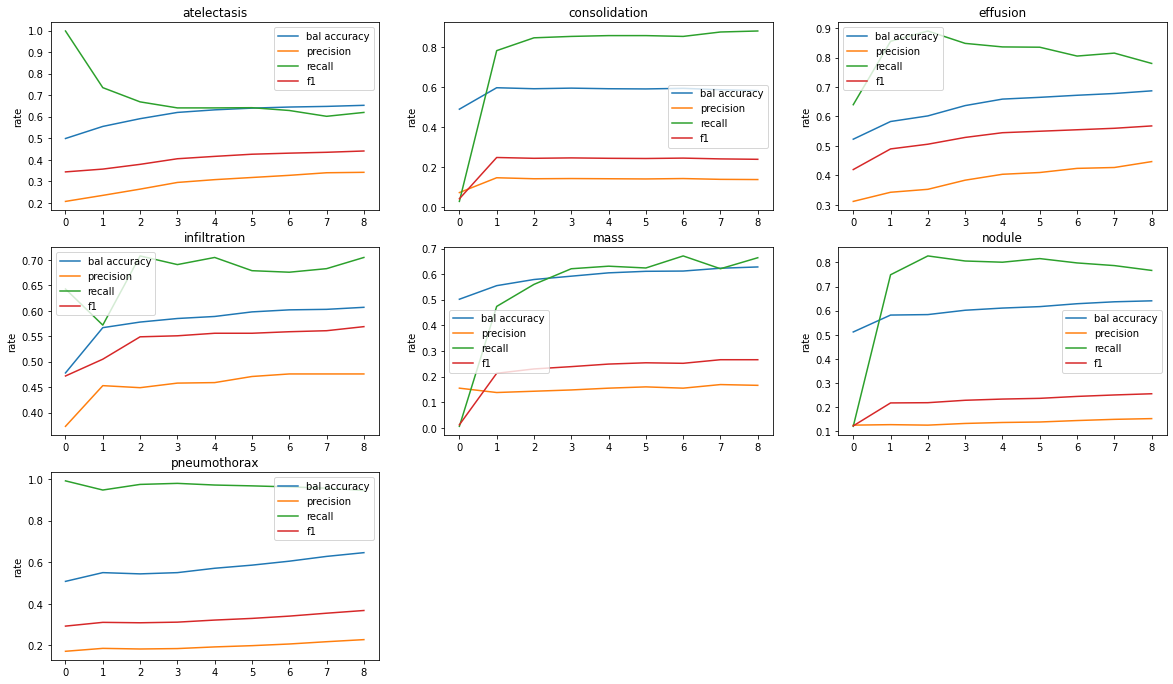

In [4]:
from matplotlib import pyplot as plt

plt.figure(figsize=(20,20))
for i in range(7):
    plt.subplot(5, 3, i + 1)
    plt.plot(range(9), bal_accs[i], label='bal accuracy')
    plt.plot(range(9), precs[i], label='precision')
    plt.plot(range(9), recs[i], label='recall')
    plt.plot(range(9), f1_scores[i], label='f1')
    plt.legend()
#     plt.plot(range(1, 11), np.array(class_accuracies_by_epochs)[:, i])
    plt.xticks(ticks=range(9))
    plt.title(labels[i])
#     plt.xlabel('epoch')
    plt.ylabel('rate')